# Land Use Land Cover (LULC) Classification

## Overview
The dataset for this study was prepared using geemap, a Python module for interactive mapping with Google Earth Engine (GEE). This code requires a GEE account to be executed, therefore please create one before executing it. USGS Landsat 8 Level 2, Collection 2, Tier 1 dataset has been used to collect the atmospherically corrected surface reflectance (SR) values. These SR images, after preprocessing, are used to derive different indices. All of these features are used to predict the LULC of the selected area of interest (aoi). The European Space Agency (ESA) WorldCover 10 m 2020 is used as the response variable. Startified sampling is done to gather characteristics from the research area, which are then saved on the local computer for later analysis. 70% of the data is utilised for training, while the remainder is used for testing. A few well-known classification algorithms, such as Random Forest (RF), KNN, SVM, and others, are used for classification. To assess the model's performance, K-fold cross validation was used. To increase model performance, feature importance was assessed, and hyperparameter adjustment was conducted.

In [1]:
import geemap
import ee
ee.Authenticate()
ee.Initialize()

Enter verification code:  4/1AdQt8qi7tR2MoqlCId154ydEYAugObfo0-5YcgrAN2tV6KF4QR7C6S6J3t4



Successfully saved authorization token.


In [7]:
aoi = ee.Geometry.Polygon(
  [[[73.5, 24],
    [73.5, 22.5],
    [72, 22.5],
    [72, 24]]], None, False)

In [10]:
Map = geemap.Map(center=[23, 73], zoom=8)
Map.addLayer(aoi)
Map

Map(center=[23, 73], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Tog…

### Bands
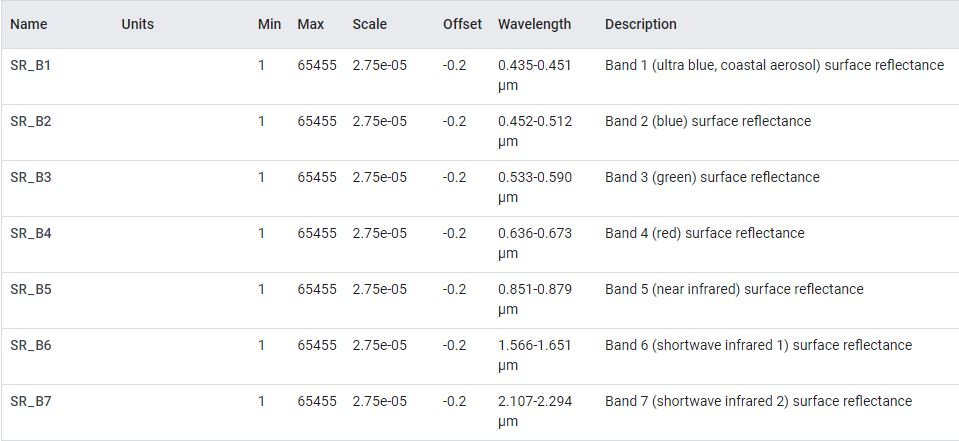

In [11]:
# Define a function that scales and masks Landsat 8 surface reflectance images.
def prepSrL8(image):
  # Develop masks for unwanted pixels (fill, cloud, cloud shadow).
  qaMask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 2)).eq(0) 
  saturationMask = image.select('QA_RADSAT').eq(0)

  # Apply the scaling factors to the appropriate bands.
  def getFactorImg(factorNames):
    factorList = image.toDictionary().select(factorNames).values()
    return ee.Image.constant(factorList)
  
  scaleImg = getFactorImg([
    'REFLECTANCE_MULT_BAND_.|TEMPERATURE_MULT_BAND_ST_B10'])
  offsetImg = getFactorImg([
    'REFLECTANCE_ADD_BAND_.|TEMPERATURE_ADD_BAND_ST_B10'])
  scaled = image.select('SR_B.|ST_B10').multiply(scaleImg).add(offsetImg)

  # Replace original bands with scaled bands and apply masks.
  return image.addBands(scaled, None, True) \
    .updateMask(qaMask).updateMask(saturationMask)

In [13]:
L8_SR = (
    ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
    .filterBounds(aoi)
    .filterDate('2020-01-01', '2020-12-31')
    .map(prepSrL8)
    .select('SR_B[1-7]')
    .median()
    .clip(aoi)
)

vis_params = {'min': 0, 'max': 1, 'bands': ['SR_B4', 'SR_B3', 'SR_B2']}
Map.addLayer(L8_SR, vis_params, "Landsat-8")
Map

Map(bottom=28764.0, center=[23, 73], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HB…

### Computation of Remote Sensing (RS) Indices

In [16]:
# Define a function that creates different RS indices and include those to the landsat images as new bands  .
def addIndex(image):
    ndvi = image.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')
    ndwi = image.normalizedDifference(['SR_B3', 'SR_B5']).rename('NDWI')
    ndbi = image.normalizedDifference(['SR_B6', 'SR_B5']).rename('NDBI')
    ndsi = image.normalizedDifference(['SR_B3', 'SR_B6']).rename('NDSI')
    return image.addBands(ndvi).addBands(ndwi).addBands(ndbi).addBands(ndsi)

In [17]:
L8_SR = addIndex(L8_SR)
L8_SR.getInfo()

{'type': 'Image',
 'bands': [{'id': 'SR_B1',
   'data_type': {'type': 'PixelType',
    'precision': 'double',
    'min': -0.2,
    'max': 1.6022125},
   'dimensions': [2, 3],
   'origin': [72, 22],
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]},
  {'id': 'SR_B2',
   'data_type': {'type': 'PixelType',
    'precision': 'double',
    'min': -0.2,
    'max': 1.6022125},
   'dimensions': [2, 3],
   'origin': [72, 22],
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]},
  {'id': 'SR_B3',
   'data_type': {'type': 'PixelType',
    'precision': 'double',
    'min': -0.2,
    'max': 1.6022125},
   'dimensions': [2, 3],
   'origin': [72, 22],
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]},
  {'id': 'SR_B4',
   'data_type': {'type': 'PixelType',
    'precision': 'double',
    'min': -0.2,
    'max': 1.6022125},
   'dimensions': [2, 3],
   'origin': [72, 22],
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]},
  {'id': 'SR_B5',
   'data_type':

In [18]:
ESA_lulc = ee.ImageCollection('ESA/WorldCover/v100').first().select('Map')

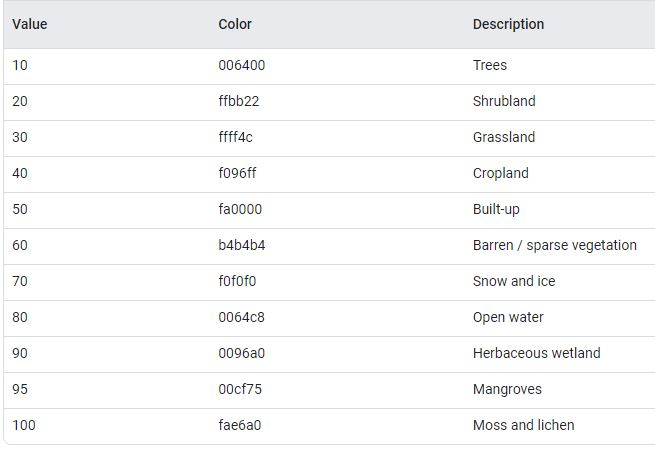

In [19]:
# Sample the input imagery to get a FeatureCollection of training data.
training = L8_SR.addBands(ESA_lulc).stratifiedSample(
    **{
  'region': aoi,
  'classBand': 'Map',
  'scale': 30,
  'numPoints': 100,
  'geometries': True,
  'seed': 0,
        })

Map.addLayer(training, {}, 'training', False)
Map

Map(bottom=14417.0, center=[24.156778233303413, 72.93273925781251], controls=(WidgetControl(options=['position…

In [20]:
print(training.size().getInfo())
print(training.first().getInfo())

800
{'type': 'Feature', 'geometry': {'geodesic': False, 'type': 'Point', 'coordinates': [73.4786418956046, 23.69652413249624]}, 'id': '0', 'properties': {'Map': 10, 'NDBI': -0.10249199718236923, 'NDSI': -0.48299479484558105, 'NDVI': 0.55821692943573, 'NDWI': -0.5578705072402954, 'SR_B1': 0.019023749999999992, 'SR_B2': 0.03321375, 'SR_B3': 0.06835875, 'SR_B4': 0.06828999999999999, 'SR_B5': 0.24086625, 'SR_B6': 0.1960825, 'SR_B7': 0.11887625000000002}}


### Export the prepared dataset to Local Computer

In [21]:
import os
out_dir = os.path.expanduser("E:/Earth_Engine")

if not os.path.exists(out_dir):
    os.makedirs(out_dir)

In [22]:
out_shp = os.path.join(out_dir, "data_observation.csv")
geemap.ee_export_vector(training, out_shp, verbose=True)

Generating URL ...
Please wait ...
Data downloaded to E:\Earth_Engine\data_observation.csv


### Machine Learning Architecture

In [31]:
# libraries
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import pandas as pd

In [25]:
input_features = pd.read_csv("E:/Earth_Engine/data_observation.csv" )
input_features.head()

,SR_B2,NDSI,SR_B3,SR_B4,SR_B5,SR_B6,NDWI,SR_B7,NDVI,SR_B1,NDBI,Map,system:index
0,0.033214,-0.482995,0.068359,0.068290,0.240866,0.196082,-0.557871,0.118876,0.558217,0.019024,-0.102492,10,0
1,0.043127,-0.562848,0.077228,0.092559,0.313480,0.276094,-0.604679,0.162794,0.544089,0.031151,-0.063412,10,1
2,0.037792,-0.490000,0.071370,0.068414,0.290517,0.208512,-0.605568,0.138594,0.618792,0.027246,-0.164329,10,2
3,0.039002,-0.472175,0.065540,0.073075,0.225425,0.182800,-0.549499,0.127167,0.510385,0.027012,-0.104415,10,3
4,0.028580,-0.475147,0.060260,0.049232,0.293900,0.169366,-0.659702,0.099186,0.713041,0.020522,-0.268817,10,4


In [26]:
input_features = input_features.drop(columns='system:index', axis = 1)
input_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SR_B2   800 non-null    float64
 1   NDSI    800 non-null    float64
 2   SR_B3   800 non-null    float64
 3   SR_B4   800 non-null    float64
 4   SR_B5   800 non-null    float64
 5   SR_B6   800 non-null    float64
 6   NDWI    800 non-null    float64
 7   SR_B7   800 non-null    float64
 8   NDVI    800 non-null    float64
 9   SR_B1   800 non-null    float64
 10  NDBI    800 non-null    float64
 11  Map     800 non-null    int64  
dtypes: float64(11), int64(1)
memory usage: 75.1 KB


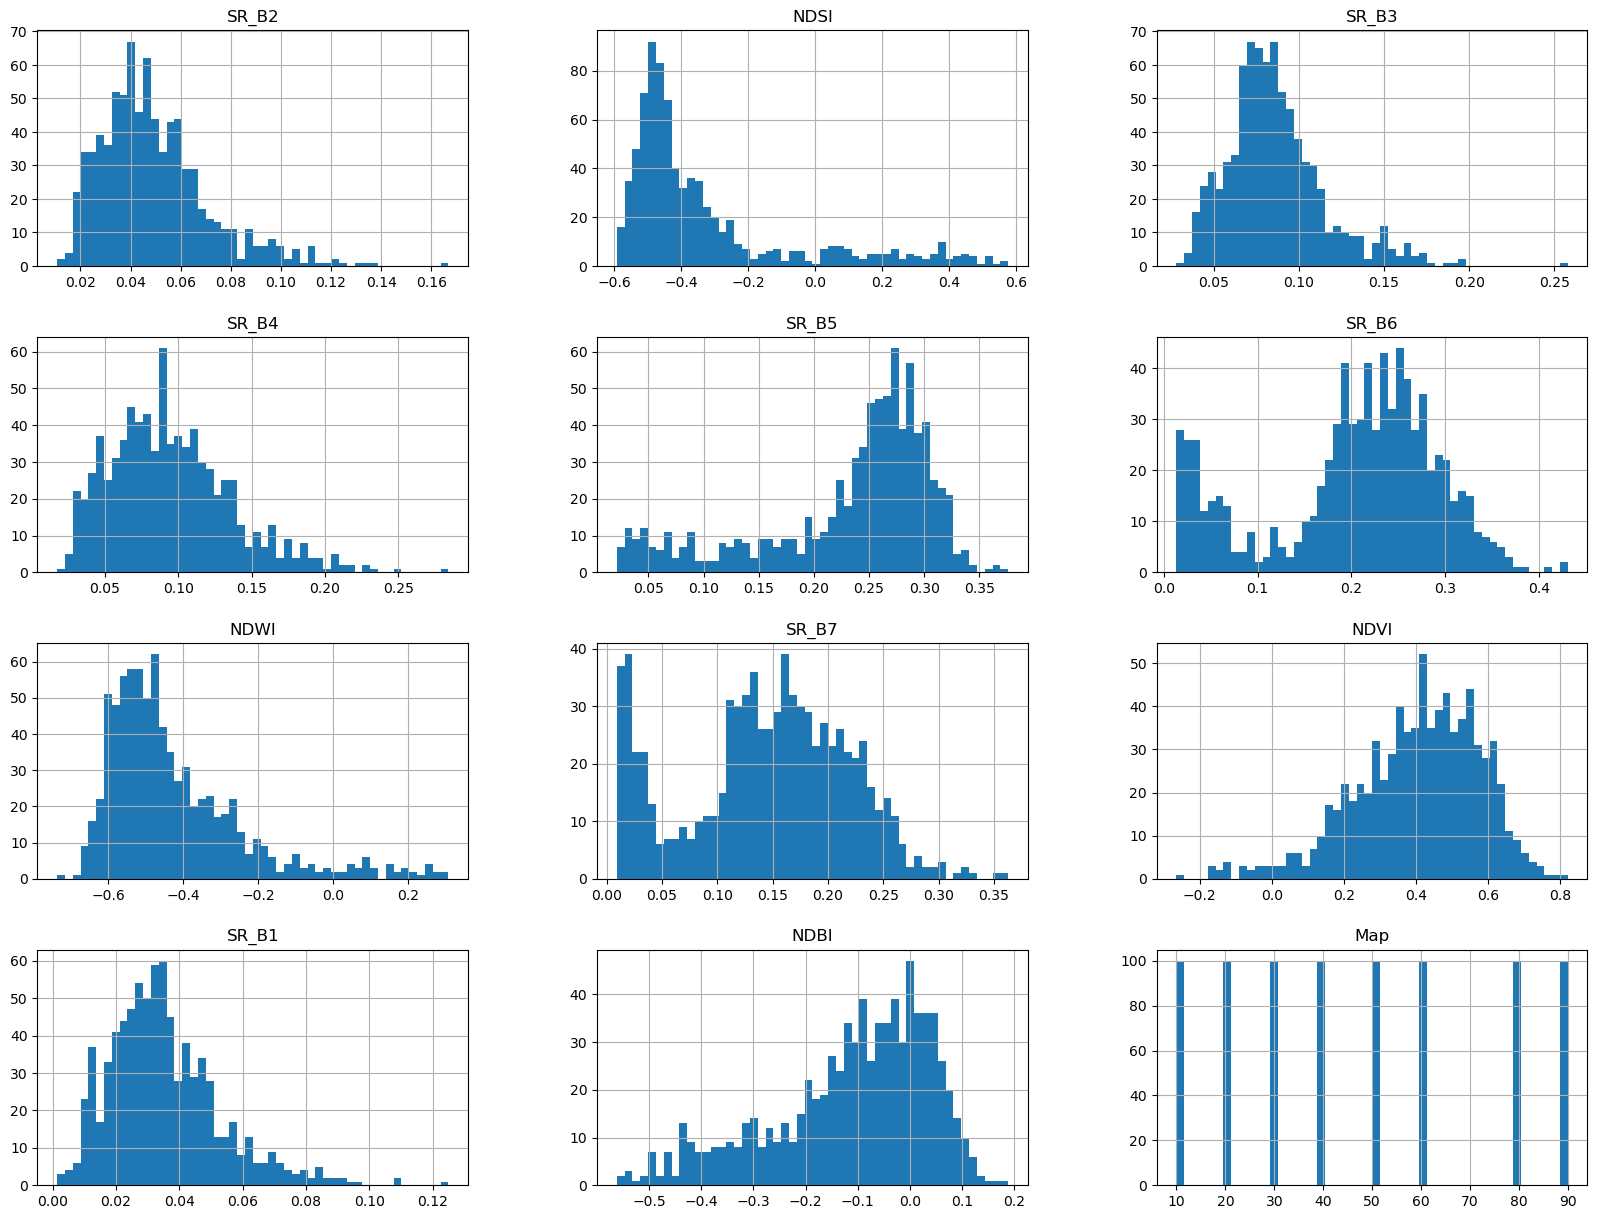

In [27]:
 %matplotlib inline
import matplotlib.pyplot as plt
input_features.hist(bins=50, figsize=(20,15))
plt.show()

In [28]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
X = input_features.drop(['Map'], axis=1)
y = input_features['Map']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [29]:
# machine learing model pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

In [30]:
model_pipeline = []
model_pipeline.append(LogisticRegression(solver = 'liblinear'))
model_pipeline.append(SVC())
model_pipeline.append(KNeighborsClassifier())
model_pipeline.append(DecisionTreeClassifier())
model_pipeline.append(RandomForestClassifier())
model_pipeline.append(GaussianNB())

In [32]:
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
 
model_list = [ 'Logistic Regression', 'SVM', 'KNN', 'Decision Tree', 'Random Forest', 'Naive Bayes']
acc_list = []
auc_list = []
cm_list = []

for model in model_pipeline:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc_list.append(metrics.accuracy_score(y_test, y_pred))
    cm_list.append(confusion_matrix(y_test, y_pred))

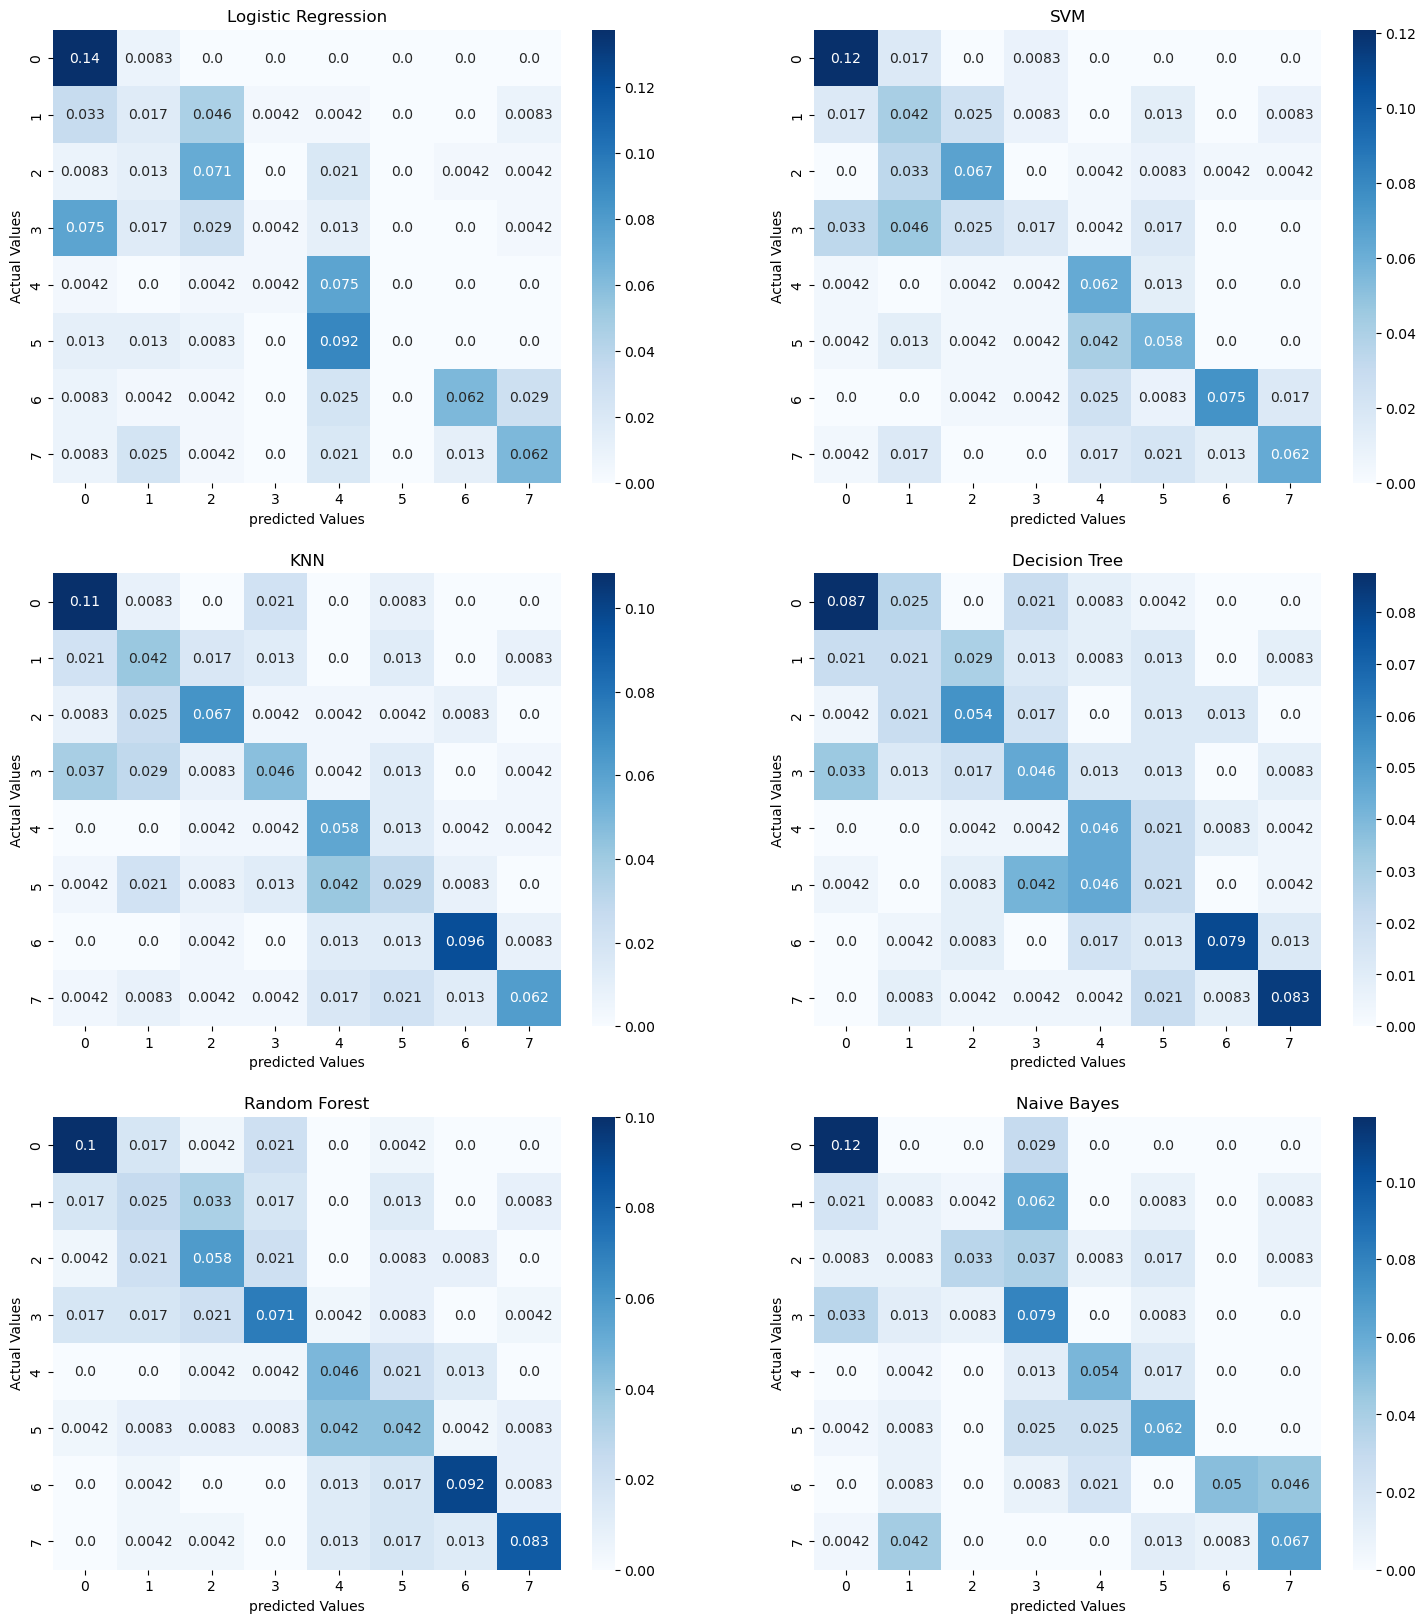

In [39]:
# plot  confusion matrix
fig = plt.figure(figsize= (18,20))
for i in range(len(cm_list)):
    cm = cm_list[i]
    model = model_list[i]
    sub = fig.add_subplot(3, 2, i+1).set_title(model)
    #cm_plot = plt.imshow( cm , cmap = 'cool' , interpolation = 'nearest')
    cm_plot =  sns.heatmap(cm/np.sum(cm),fmt='.2', annot = True, cmap = 'Blues')
    cm_plot.set_xlabel('predicted Values')
    cm_plot.set_ylabel('Actual Values')

In [40]:
result_df = pd.DataFrame({'Model' : model_list, 'Accuracy': acc_list})
result_df

,Model,Accuracy
0,Logistic Regression,0.429167
1,SVM,0.504167
2,KNN,0.508333
3,Decision Tree,0.437500
4,Random Forest,0.516667
5,Naive Bayes,0.470833


In [41]:
# K-fold cross-validation
from sklearn.model_selection import cross_val_score
model = RandomForestClassifier()
scores = cross_val_score(model, X_train, y_train, cv=10)

In [42]:
print("scores:", scores)
print("Mean:", scores.mean())
print("Standard deviation:", scores.std())

scores: [0.625      0.51785714 0.55357143 0.5        0.60714286 0.60714286
 0.57142857 0.5        0.57142857 0.48214286]
Mean: 0.5535714285714285
Standard deviation: 0.04857668038834085


Feature: 0, Score: 0.06825
Feature: 1, Score: 0.13492
Feature: 2, Score: 0.06841
Feature: 3, Score: 0.07114
Feature: 4, Score: 0.09093
Feature: 5, Score: 0.08061
Feature: 6, Score: 0.11759
Feature: 7, Score: 0.08697
Feature: 8, Score: 0.09580
Feature: 9, Score: 0.06646
Feature: 10, Score: 0.11892


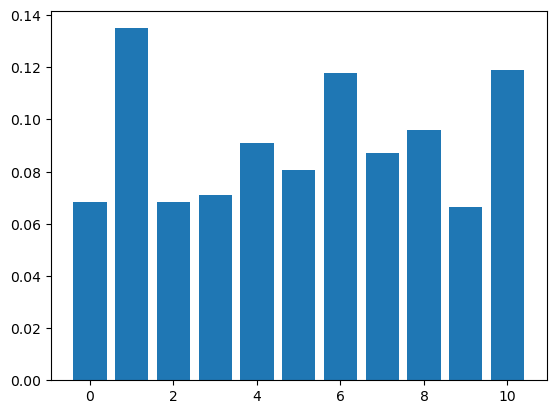

In [43]:
# random forest for feature importance on a classification problem
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot
# define dataset
#X, y = make_regression(n_samples=1000, n_features=10, n_informative=5, random_state=1)
# define the model
model = RandomForestClassifier()
# fit the model
model.fit(X_train, y_train)
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

### Hyperparameter Tuning

In [48]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 80, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [2,4]
# Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
bootstrap = [True, False]

In [49]:
# Create the param grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(param_grid)

{'n_estimators': [10, 17, 25, 33, 41, 48, 56, 64, 72, 80], 'max_features': ['auto', 'sqrt'], 'max_depth': [2, 4], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2], 'bootstrap': [True, False]}


In [50]:
from sklearn.model_selection import RandomizedSearchCV
model = RandomForestClassifier()
rf_RandomGrid = RandomizedSearchCV(estimator = model, param_distributions = param_grid, cv = 10, verbose=2, n_jobs = 4)

In [51]:
rf_RandomGrid.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=4,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [2, 4],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': [10, 17, 25, 33, 41, 48,
                                                         56, 64, 72, 80]},
                   verbose=2)

In [52]:
rf_RandomGrid.best_params_

{'n_estimators': 41,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 4,
 'bootstrap': True}

In [53]:
print (f'Train Accuracy - : {rf_RandomGrid.score(X_train,y_train):.3f}')
print (f'Test Accuracy - : {rf_RandomGrid.score(X_test,y_test):.3f}')

Train Accuracy - : 0.625
Test Accuracy - : 0.517
